# 1- Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler


# Classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier


from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline


#Evauluation Metrics
from sklearn.metrics import accuracy_score,f1_score,classification_report,confusion_matrix
from sklearn.metrics import precision_recall_curve, auc,roc_auc_score,roc_curve
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

import pickle
import warnings
from sklearn.exceptions import ConvergenceWarning

warnings.filterwarnings("ignore", category=ConvergenceWarning)
warnings.filterwarnings("ignore", category= FutureWarning)

<frozen importlib._bootstrap>:488: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 216 from C header, got 232 from PyObject


# 2 - Importing Dataset

In [495]:
df = pd.read_csv("../data/cleaned_data.csv")
df.iloc[30479]

person_age                      40.5
person_income                54000.0
home_ownership_type         MORTGAGE
employement_duration             1.0
loan_intent                EDUCATION
loan_grade                         D
loan_amount                   7750.0
loan_int_rate                  16.07
loan_status                        1
loan_percent_income             0.14
loan_default                       N
credit_history_duration         13.0
Name: 30479, dtype: object

,person_age,person_income,employement_duration,loan_amount,loan_int_rate,loan_status,loan_percent_income,credit_history_duration,loan_grade_encoded,home_ownership_type_OTHER,home_ownership_type_OWN,home_ownership_type_RENT,loan_intent_EDUCATION,loan_intent_HOMEIMPROVEMENT,loan_intent_MEDICAL,loan_intent_PERSONAL,loan_intent_VENTURE
0,22.0,42000.0,6.0,7000.0,12.68,0,0.17,2.0,2.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,24.0,108000.0,1.0,23125.0,13.99,1,0.23,2.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,22.0,38400.0,6.0,8000.0,7.88,0,0.21,4.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
3,22.0,125000.0,3.0,18000.0,14.79,0,0.14,3.0,2.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
4,34.0,97356.0,12.0,20000.0,13.22,0,0.21,7.0,2.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53367,22.0,95000.0,2.0,5000.0,10.59,0,0.05,2.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
53368,25.0,34800.0,2.0,5000.0,16.02,1,0.14,3.0,3.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
53369,36.0,43000.0,6.0,4000.0,13.92,0,0.09,14.0,2.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
53370,25.0,95950.0,2.0,17500.0,11.71,0,0.18,2.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0


# 3- Encoding Categorical Variables

In [490]:
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, LabelEncoder
import pandas as pd

# Step 1: One-Hot Encoding (with drop_first to avoid dummy variable trap)
ohe_ownership = OneHotEncoder(drop='first', sparse_output=False)
ohe_intent = OneHotEncoder(drop='first', sparse_output=False)

ownership_encoded = ohe_ownership.fit_transform(df[["home_ownership_type"]])
intent_encoded = ohe_intent.fit_transform(df[["loan_intent"]])

# Convert encoded arrays to DataFrames with proper column names
ownership_df = pd.DataFrame(ownership_encoded, columns=ohe_ownership.get_feature_names_out(["home_ownership_type"]))
intent_df = pd.DataFrame(intent_encoded, columns=ohe_intent.get_feature_names_out(["loan_intent"]))

# Set index to match original df
ownership_df.index = df.index
intent_df.index = df.index

# Step 2: Ordinal Encoding for loan_grade
ordinal = OrdinalEncoder(categories=[['A', 'B', 'C', 'D', 'E', 'F', 'G']])
df['loan_grade_encoded'] = ordinal.fit_transform(df[['loan_grade']])

# Step 3: Drop original categorical columns
df_cleaned = df.drop(['home_ownership_type', 'loan_intent', 'loan_grade'], axis=1)

# Step 4: Concatenate everything into final dataset
df_encoded = pd.concat([df_cleaned, ownership_df, intent_df], axis=1)

# Step 5: Encode target variable
le = LabelEncoder()
df_encoded['loan_default'] = le.fit_transform(df_encoded['loan_default'])


# 4- Handling Imbalance in Dataset by Oversampling Techniquw

In [491]:
# Count how many records belong to each class
majority_count = len(df_encoded[df_encoded["loan_default"] == 0])
minority_count = len(df_encoded[df_encoded["loan_default"] == 1])

# Subset the actual data (not just boolean masks)
majority = df_encoded[df_encoded["loan_default"] == 0]
minority = df_encoded[df_encoded["loan_default"] == 1]


new_minority = minority.sample(majority_count,replace=True)
new_df = pd.concat([majority,new_minority],axis=0)
new_df["loan_default"].value_counts()

new_df = new_df.sample(frac=1, random_state=42).reset_index(drop=True)


X_corr = df_encoded
X = new_df.drop('loan_default', axis=1)
y = new_df['loan_default']
X.shape


(53372, 17)

<Axes: >

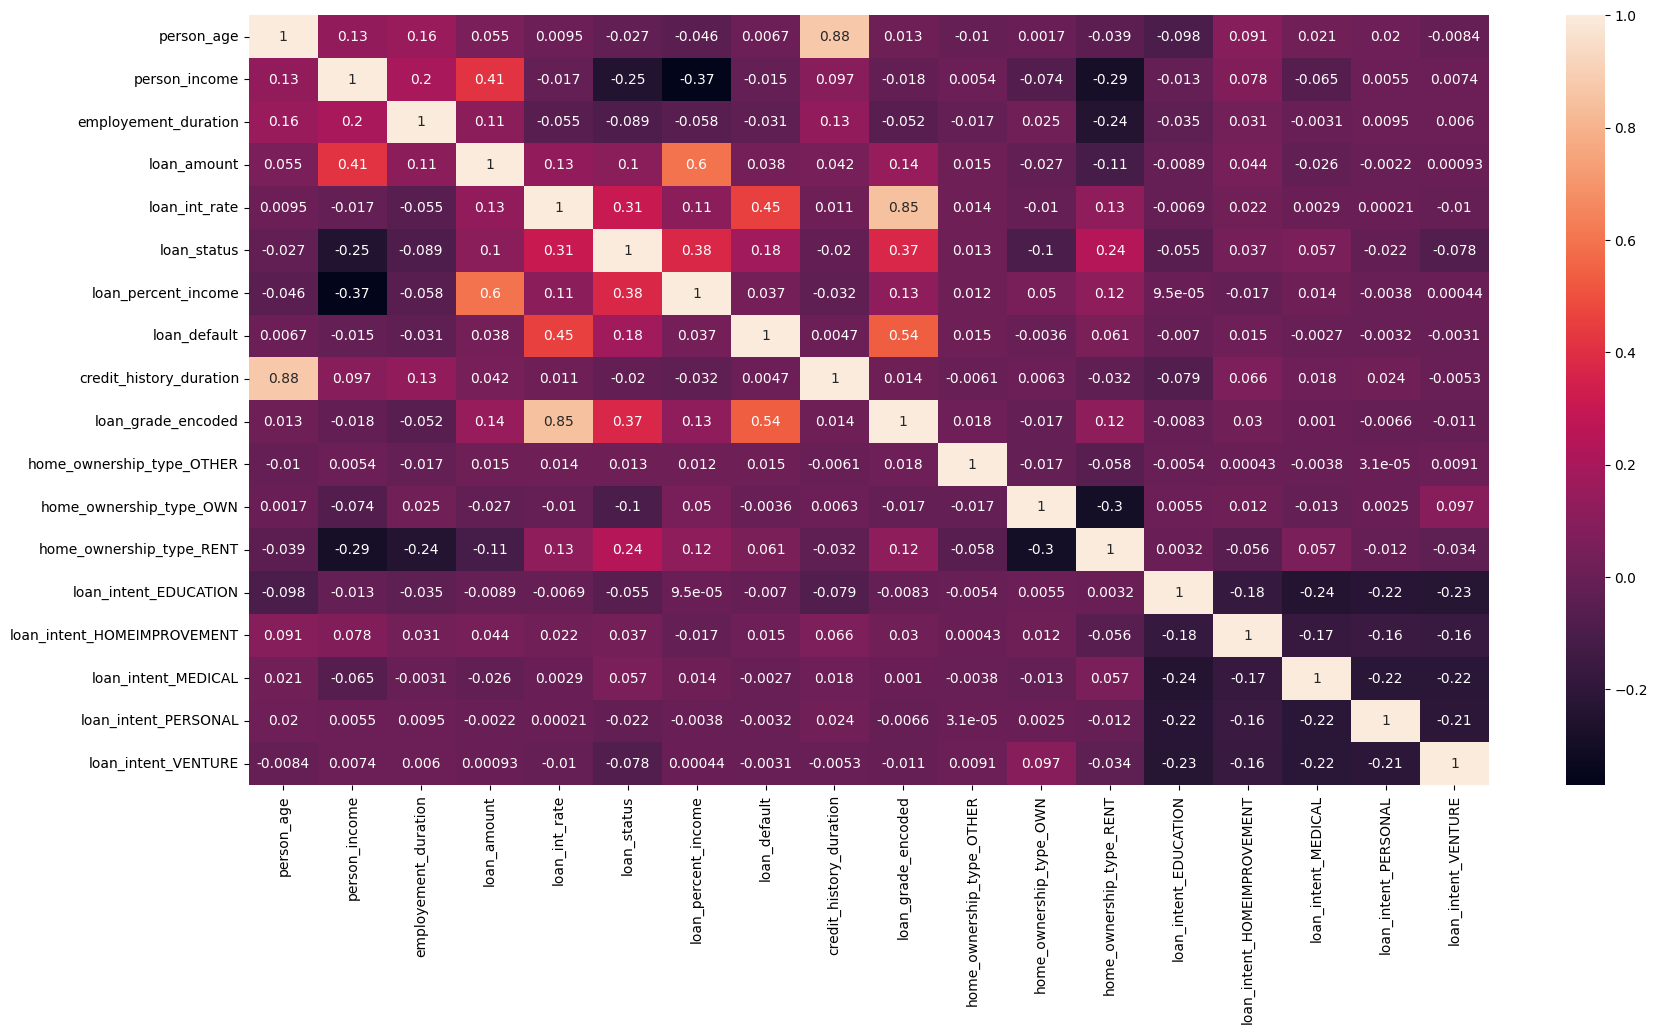

In [449]:
plt.figure(figsize=(20,10))
sns.heatmap(X_corr.corr(),annot=True)

# 5- Standardization/Scaling

In [450]:
X_train,X_test,y_train,y_test  =train_test_split(X,y,test_size=0.3,stratify=y,random_state=42)

In [493]:
y_test

30479    0
28644    0
3165     1
21935    1
36815    0
        ..
36347    1
520      1
49612    1
17993    0
45408    0
Name: loan_default, Length: 16012, dtype: int64

In [451]:
from sklearn.preprocessing import StandardScaler
scaler  =StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# 5- Training/Predicting using Multiple Models

In [452]:
models = {
    "LogisticRegression": LogisticRegression(solver="saga", penalty="elasticnet", max_iter=10),
    "AdaBoostClassifier": AdaBoostClassifier(),
    "RandomForestClassifier": RandomForestClassifier(),
    "CatBoostClassifier": CatBoostClassifier(verbose=0),
    "XGBClassifier": XGBClassifier(eval_metric="logloss", use_label_encoder=False)
}

params = {
    "LogisticRegression": {
        "l1_ratio": [0.0, 0.5, 1.0],
        "C": [0.1, 1, 10]
    },
    "AdaBoostClassifier": {
        "n_estimators": [50, 100, 200],
        "learning_rate": [0.01, 0.1, 1]
    },
    "RandomForestClassifier": {
        "n_estimators": [100, 200],
        "max_depth": [10, 30, 50],
        "min_samples_split": [2, 5],
        "min_samples_leaf": [1, 2]
    },
    "CatBoostClassifier": {
        "iterations": [100, 200],
        "depth": [4, 6, 10],
        "learning_rate": [0.01, 0.1]
    },
    "XGBClassifier": {
        "n_estimators": [100, 200],
        "max_depth": [3, 6, 10],
        "learning_rate": [0.01, 0.1],
        "subsample": [0.8, 1]
    }

}



for name, model in models.items():
    print(f"\n Running GridSearchCV for: {name}")
    grid = GridSearchCV(estimator=model, param_grid=params[name], cv=2, scoring='accuracy', n_jobs=-1)
    grid.fit(X_train, y_train)
    best_model = grid.best_estimator_
    print(f"Best Score: {grid.best_score_:.4f}")
    print(f"Best Params: {grid.best_params_}")



 Running GridSearchCV for: LogisticRegression


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The ma

Best Score: 0.8864
Best Params: {'C': 0.1, 'l1_ratio': 1.0}

 Running GridSearchCV for: AdaBoostClassifier


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R

Best Score: 0.8965
Best Params: {'learning_rate': 1, 'n_estimators': 100}

 Running GridSearchCV for: RandomForestClassifier
Best Score: 0.8969
Best Params: {'max_depth': 30, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}

 Running GridSearchCV for: CatBoostClassifier
Best Score: 0.8975
Best Params: {'depth': 10, 'iterations': 200, 'learning_rate': 0.1}

 Running GridSearchCV for: XGBClassifier


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [10:46:29] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [10:46:29] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [10:46:29] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [10:46:29] WARNING: /Users/runner/work/xgboost/xgboost/src

Best Score: 0.8971
Best Params: {'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 200, 'subsample': 1}


In [453]:
best_model = grid.best_estimator_


# Step 2: Train And Predict using out best model
best_model.fit(X_train,y_train)
y_pred = best_model.predict(X_test)


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [10:46:33] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


# 6 - Evaluation of Best Model

In [454]:
print(f"accuracy_score:{accuracy_score(y_test,y_pred)}")
print(f"f1:{f1_score(y_test,y_pred)}")
print(f"classification_report:{classification_report(y_test,y_pred)}")
print(f"confusion_matrix:{confusion_matrix(y_test,y_pred)}")

accuracy_score:0.8945166125405946
f1:0.9044845331674489
classification_report:              precision    recall  f1-score   support

           0       1.00      0.79      0.88      8006
           1       0.83      1.00      0.90      8006

    accuracy                           0.89     16012
   macro avg       0.91      0.89      0.89     16012
weighted avg       0.91      0.89      0.89     16012

confusion_matrix:[[6326 1680]
 [   9 7997]]


SInce there is huge Imbalance in dataset so Accuracy is not a reliable metrics here so We will rely on precision Recall Curve based on the Problem Statement where Getting to Know the Defaults are much more important than anything else in credit risk Modeling

# Using Precision/Recall Curve for Imbalanced Dataset Evaluation

In [455]:
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve, auc

# 1. Predict probabilities for class 1
y_prob = best_model.predict_proba(X_test)[:, 1]

# 2. Precision-Recall curve
precision, recall, pr_thresholds = precision_recall_curve(y_test, y_prob)
pr_auc = auc(recall, precision)

# 3. ROC curve
fpr, tpr, roc_thresholds = roc_curve(y_test, y_prob)
roc_auc = roc_auc_score(y_test, y_prob)

print(" ROC AUC:", roc_auc)
print("PR AUC:", pr_auc)


 ROC AUC: 0.9353732187119965
PR AUC: 0.9036874559507069


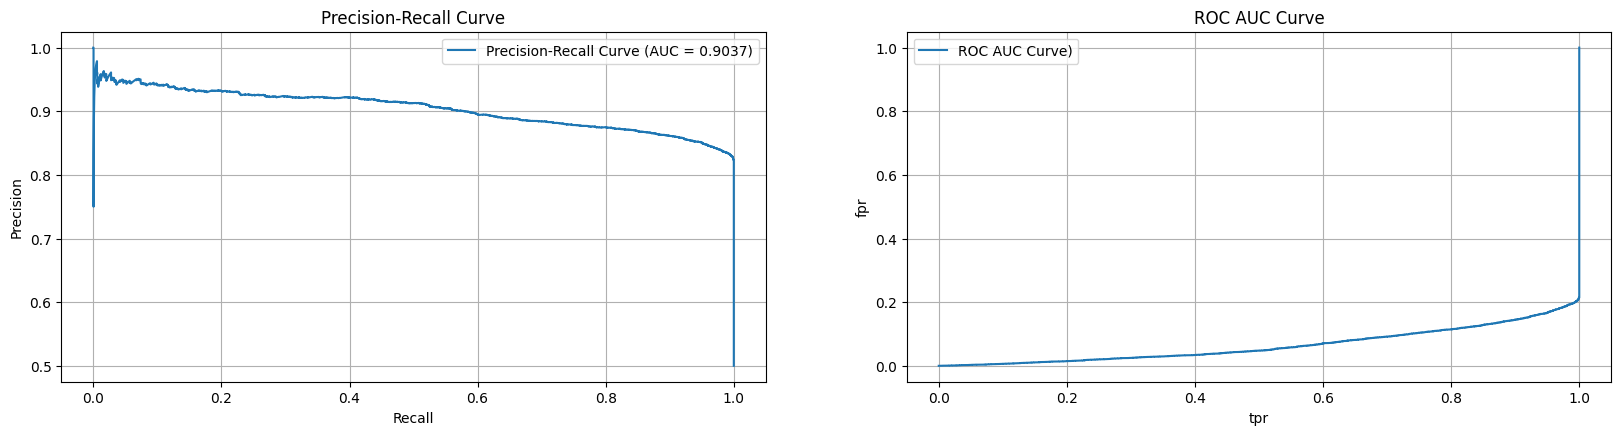

In [456]:
# 4 - Plotting Precision Recall Curve
plt.figure(figsize=(20,10))
plt.subplot(2,2,1)
plt.plot(recall, precision, label=f'Precision-Recall Curve (AUC = {pr_auc:.4f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.grid(True)
plt.legend()

plt.subplot(2,2,2)
plt.plot(tpr, fpr, label=f'ROC AUC Curve)')
plt.xlabel('tpr')
plt.ylabel('fpr')
plt.title('ROC AUC Curve')
plt.grid(True)
plt.legend()
plt.show()



In [457]:
comparing_prediction = pd.DataFrame({"Actual":y_test,"Predicted":y_pred})
comparing_prediction.sample(10)

,Actual,Predicted
48708,0,0
31644,0,1
50432,1,1
27516,1,1
43850,0,0
39411,0,1
47424,0,0
7303,0,1
21229,1,1
49194,0,1


# 7- Testing Our Model with New Input

In [458]:
# 1. Input new data
sample_input = {
    "person_age": 26.0,
    "person_income": 45000.0,
    "home_ownership_type": "RENT",
    "employement_duration": 2.0,
    "loan_intent": "PERSONAL",
    "loan_grade": "C",
    "loan_amount": 4800.0,
    "loan_int_rate": 13.06,
    "loan_status": 0,
    "loan_percent_income": 0.11,
    "credit_history_duration": 4.0
}

data = pd.DataFrame([sample_input])

# 2. Apply pre-fitted encoders (use .transform, NOT .fit_transform)
ownership_encoded = ohe_ownership.transform(data[["home_ownership_type"]])
intent_encoded = ohe_intent.transform(data[["loan_intent"]])

ownership_df = pd.DataFrame(ownership_encoded, columns=ohe_ownership.get_feature_names_out(["home_ownership_type"]))
intent_df = pd.DataFrame(intent_encoded, columns=ohe_intent.get_feature_names_out(["loan_intent"]))

# Set index to match data
ownership_df.index = data.index
intent_df.index = data.index

# 3. Ordinal encoding for loan_grade
data['loan_grade_encoded'] = ordinal.transform(data[['loan_grade']])

# 4. Drop unused original categorical columns
df_cleaned = data.drop(['home_ownership_type', 'loan_intent', 'loan_grade'], errors='ignore', axis=1)

# 5. Final input DataFrame
df_encoded = pd.concat([df_cleaned, ownership_df, intent_df], axis=1)

# 6. Scale
X_transformed = scaler.transform(df_encoded)


# 7. Predict
prediction = best_model.predict(X_transformed)[0]
print("Predicted loan default:", le.inverse_transform(np.array([prediction]))[0])



Predicted loan default: Y


# 8 - Model Explainability using SHAP/LIME

Model Explainability is a way to understand,interpret or debug how AI model make decision. It help us understand im,portance of feature and what contributed to specific decision.
This matters because in credit-risk modeling where risk is high we need to ensure the factors that contributed in making model take specific decision such as if customer is likely going to defualt or not.
Model Explainability help build trust and transparency in AI model.

## Model Explainability Techniques

1. **LIME (Local Interpretable Model-agnostic Explanations)**
   - LIME is a model agnostic technique used to explain individual prediction of any model
   - It approximates the model locally by running it one row ar a time
   - Its faster


   2 -**SHAP(shapely additive Explanation)**
   - SHAP is model agnostic explanation which work by assigning a contribtuion value(shapely value) to each feature based on game theory.
   - It works on both locally and Global
   - Its slower because of more computation


# (A) - SHAP(shapely additive Explainable)

In [459]:
import sys
!{sys.executable} -m pip install shap



[notice] A new release of pip is available: 24.3.1 -> 25.2
[notice] To update, run: python3 -m pip install --upgrade pip


# - SHAP for Global Explainability

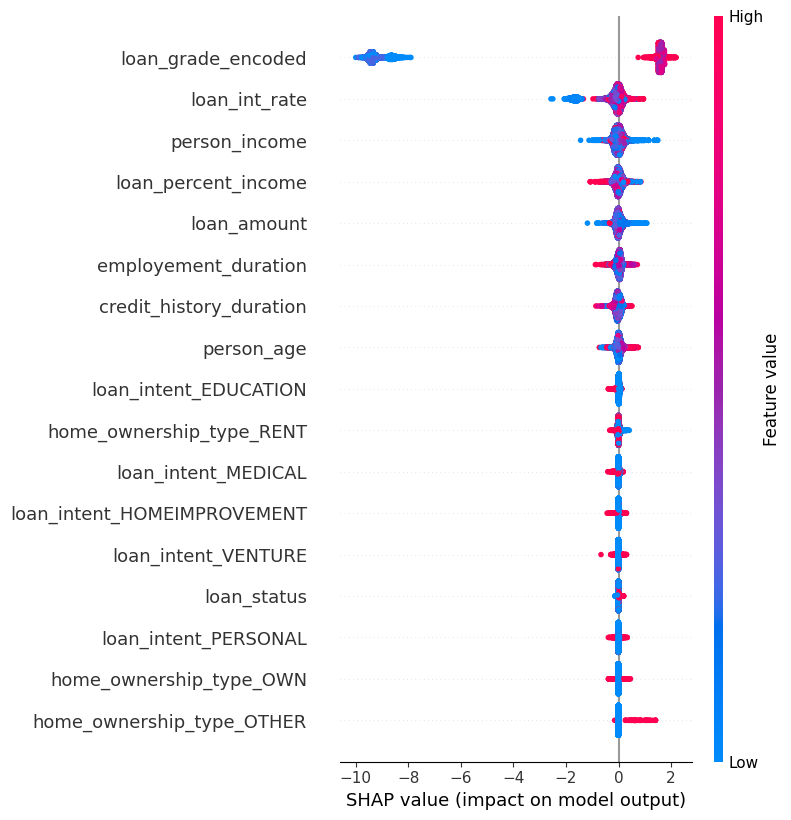

In [470]:
X_test = pd.DataFrame(X_test, columns=X.columns)

import shap
explainer = shap.Explainer(best_model)
shap_values = explainer(X_test)
shap.summary_plot(shap_values, X_test)

# - SHAP for Local Explainability(means for specific Customer)

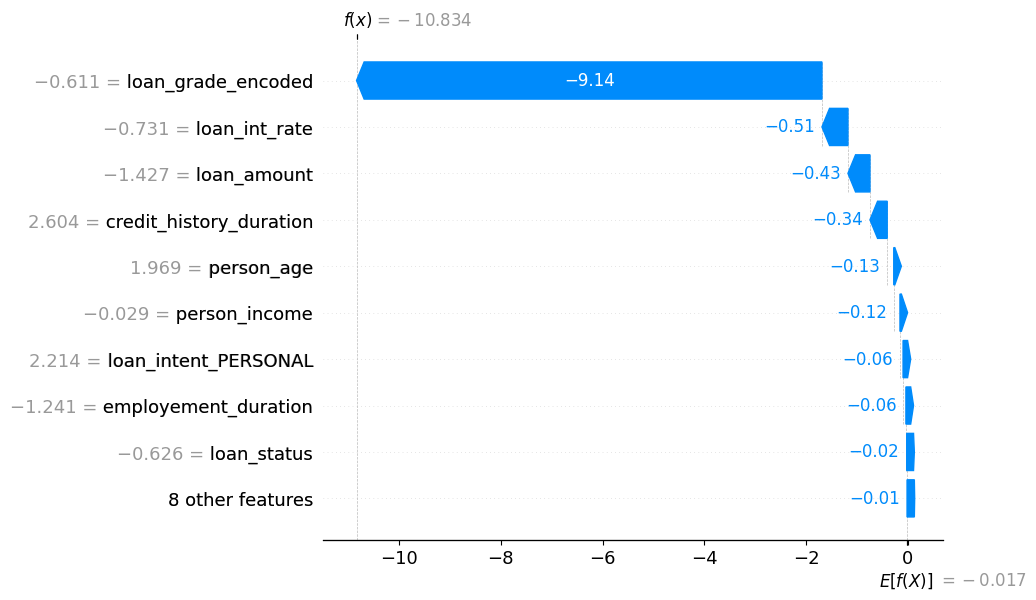

In [498]:
import shap

# Get SHAP values for X_test
shap_values = explainer(X_test)

# Plot waterfall for first prediction
shap.plots.waterfall(shap_values[0])


“In the SHAP summary plot, when Loan_Grade_Encoded is blue (i.e., low-encoded loan grade such as A or B), the SHAP values are negative, meaning the model is less likely to predict a default — which aligns with expectations that better loan grades are associated with lower risk.”

In [499]:
shap.initjs()
print(df.iloc[30479])
shap.plots.force(shap_values[0]) 


person_age                      40.5
person_income                54000.0
home_ownership_type         MORTGAGE
employement_duration             1.0
loan_intent                EDUCATION
loan_grade                         D
loan_amount                   7750.0
loan_int_rate                  16.07
loan_status                        1
loan_percent_income             0.14
loan_default                       N
credit_history_duration         13.0
Name: 30479, dtype: object


# (B) - LIME(Local Interpretable model agnostic Explainable)
only used for Local Interpretation

In [500]:
import sys
!{sys.executable} -m pip install lime

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.2/13.2 MB 407.4 kB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 50.1 kB/s eta 0:00:00a 0:00:05
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283913 sha256=3b1a1c09671011a3c2eb1f0dfe0d593f96c2173df0ee1f4789e99b99d8814b14
  Stored in directory: /Users/prabhsandhu/Library/Caches/pip/wheels/e7/5d/0e/4b4fff9a47468fed5633211fb3b76d1db43fe806a17fb7486a
Successfully built lime
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.

[notice] A new release of pip is available: 24.3.1 -> 25.2
[notice] To update, run: python3 -m pip install --upgrade pip


person_age                      40.5
person_income                54000.0
home_ownership_type         MORTGAGE
employement_duration             1.0
loan_intent                EDUCATION
loan_grade                         D
loan_amount                   7750.0
loan_int_rate                  16.07
loan_status                        1
loan_percent_income             0.14
loan_default                       N
credit_history_duration         13.0
Name: 30479, dtype: object


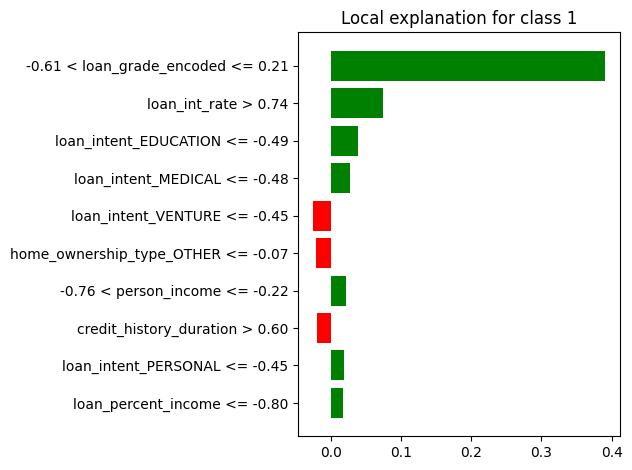

In [528]:
import lime
import lime.lime_tabular


explainer = lime.lime_tabular.LimeTabularExplainer(training_data=np.array(X_train),
         feature_names= X.columns,
         class_names=[0,1], 
         mode = "classification")


exp = explainer.explain_instance(X_test.iloc[2],predict_fn=best_model.predict_proba,num_features=10)

plt = exp.as_pyplot_figure()
plt.tight_layout()

print(df.iloc[30479])



In [529]:
from IPython.display import HTML

html_data = exp.as_html()
display(HTML(html_data))